In [4]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats

# Import data

In [68]:
# integrated_data = pd.read_csv("../data/processed/burke_ortizbobea_integrated_dataset.csv")
integrated_data = pd.read_csv("../data/processed/burke_ortizbobea_integrated_dataset_with_custom_temp.csv")

# Create unweighted to weighted temp transformation dictionary

In [72]:
unweighted_temps = integrated_data["Unweighted_Temp"]
ag_weighted_temps = integrated_data["Ag_Weighted_Temp"]
burke_pop_weighted_temps = integrated_data["Pop_Weighted_Temp_burke"]
custom_pop_weighted_temps = integrated_data["Pop_Weighted_Temp_custom"]
countries = integrated_data["Country"]
country_count = 0
colors = []
for country in countries:
    colors.append(country_count)
    country_count += 1

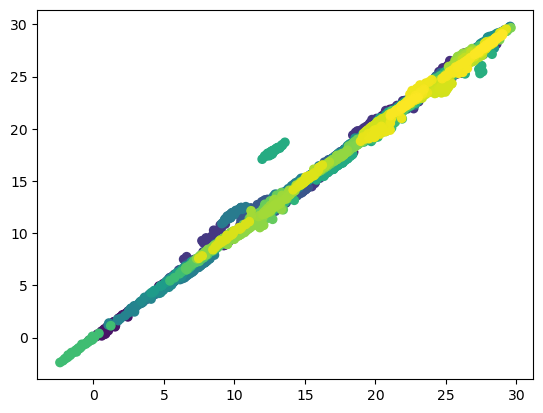

In [49]:
plt.scatter(burke_pop_weighted_temps,custom_pop_weighted_temps,c=colors)
plt.show()

In [70]:
transformation = {}
for index in range(len(unweighted_temps)):
    unweighted_temp = unweighted_temps[index]
    ag_temp = ag_weighted_temps[index]
    custom_pop_temp = custom_pop_weighted_temps[index]
    burke_pop_temp = burke_pop_weighted_temps[index]
    country = countries[index]
    if not np.isnan(custom_pop_temp) and not np.isnan(ag_temp) and not np.isnan(unweighted_temp) and not np.isnan(burke_pop_temp):
        if country not in transformation:
            transformation[country] = {}
            country_count += 1
        country_transformation= transformation[country]
        if unweighted_temp not in country_transformation:
            country_transformation[unweighted_temp] = {"ag_weighted":[],"burke_pop_weighted":[],"custom_pop_weighted":[]}
        country_transformation[unweighted_temp]["ag_weighted"].append(ag_temp)
        country_transformation[unweighted_temp]["burke_pop_weighted"].append(burke_pop_temp)
        country_transformation[unweighted_temp]["custom_pop_weighted"].append(custom_pop_temp)

In [64]:
from sklearn.linear_model import LinearRegression
count = 0
ag_scores = []
pop_scores = []
for country, trans in transformation.items():
    count += 1
    ag_weighted = []
    pop_weighted = []
    unweighted_with_ag = []
    unweighted_with_pop = []
    for unweighted_temp, weighted_temps in trans.items():
        for ag_weighted_temp in weighted_temps["ag_weighted"]:
            unweighted_with_ag.append(unweighted_temp)
            ag_weighted.append(ag_weighted_temp)
        for pop_weighted_temp in weighted_temps["pop_weighted"]:
            unweighted_with_pop.append(unweighted_temp)
            pop_weighted.append(pop_weighted_temp)
    x_pop = np.array(unweighted_with_pop).reshape(-1,1)
    y_pop = np.array(pop_weighted).reshape(-1,1)
    x_ag = np.array(unweighted_with_ag).reshape(-1,1)
    y_ag = np.array(ag_weighted).reshape(-1,1)
    pop_linreg = LinearRegression().fit(x_pop, y_pop)
    pop_scores.append(pop_linreg.score(x_pop, y_pop))
    ag_linreg = LinearRegression().fit(x_ag, y_ag)
    ag_scores.append(ag_linreg.score(x_ag, y_ag))
print(np.mean(pop_scores))
print(np.mean(ag_scores))
print(np.std(pop_scores))
print(np.std(ag_scores))

KeyError: 'pop_weighted'

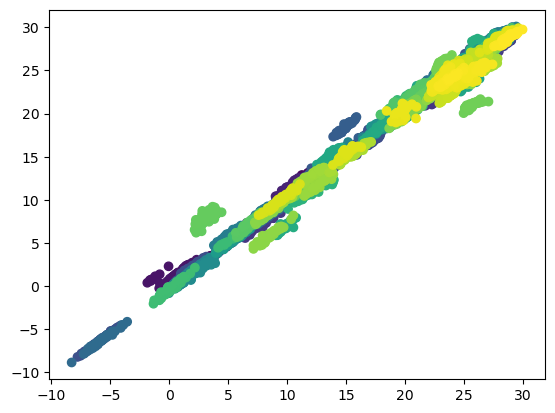

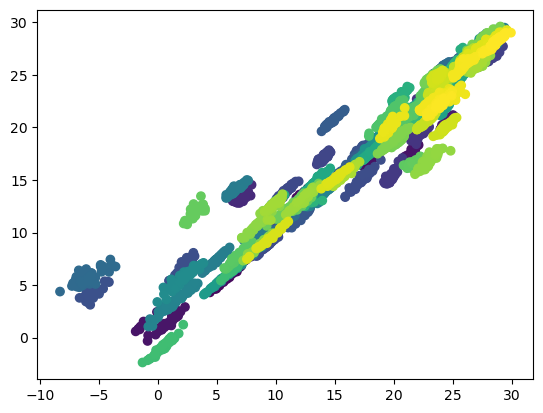

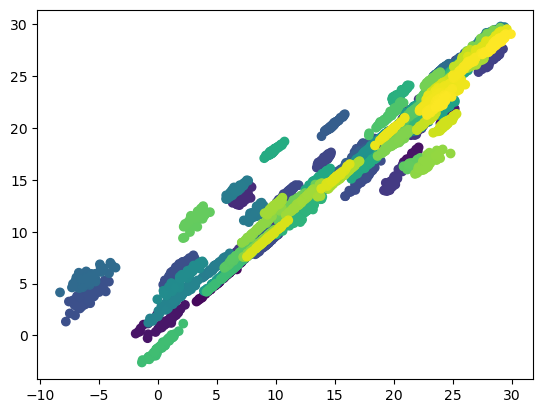

0.985597871884669
0.9287129842657343
0.9288759225869488


In [73]:
burke_pop_temp = []
custom_pop_temp = []
ag_temp = []
unweighted_burke_pop_temp = []
unweighted_custom_pop_temp = []
unweighted_ag_temp = []
for i in range(len(unweighted_temps)):
    if not np.isnan(unweighted_temps[i]) and not np.isnan(burke_pop_weighted_temps)[i]:
        unweighted_burke_pop_temp.append(unweighted_temps[i])
        burke_pop_temp.append(burke_pop_weighted_temps[i])
    if not np.isnan(unweighted_temps[i]) and not np.isnan(custom_pop_weighted_temps)[i]:
        unweighted_custom_pop_temp.append(unweighted_temps[i])
        custom_pop_temp.append(custom_pop_weighted_temps[i])
    if not np.isnan(unweighted_temps[i]) and not np.isnan(ag_weighted_temps)[i]:
        unweighted_ag_temp.append(unweighted_temps[i])
        ag_temp.append(ag_weighted_temps[i])
plt.scatter(unweighted_temps,ag_weighted_temps,c=colors)
plt.show()
plt.scatter(unweighted_temps,burke_pop_weighted_temps,c=colors)
plt.show()
plt.scatter(unweighted_temps,custom_pop_weighted_temps,c=colors)
plt.show()
ag_linreg = LinearRegression().fit(np.array(unweighted_ag_temp).reshape(-1,1), np.array(ag_temp).reshape(-1,1))
custom_pop_linreg = LinearRegression().fit(np.array(unweighted_custom_pop_temp).reshape(-1,1), np.array(custom_pop_temp).reshape(-1,1))
burke_pop_linreg = LinearRegression().fit(np.array(unweighted_burke_pop_temp).reshape(-1,1), np.array(burke_pop_temp).reshape(-1,1))
print(ag_linreg.score(np.array(unweighted_ag_temp).reshape(-1,1), np.array(ag_temp).reshape(-1,1)))
print(burke_pop_linreg.score(np.array(unweighted_burke_pop_temp).reshape(-1,1), np.array(burke_pop_temp).reshape(-1,1)))
print(custom_pop_linreg.score(np.array(unweighted_custom_pop_temp).reshape(-1,1), np.array(custom_pop_temp).reshape(-1,1)))

# Build isolated Burke model

In [14]:
with pm.Model() as model:
    
    burke_temp_prior = pm.Normal("temp_prior", 0, 30, shape=(1,3))
    burke_temp_std = pm.HalfNormal("temp_std", 30, shape=3)
    burke_temp_mixture_weights = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    burke_temp_posterior = pm.NormalMixture("temp_posterior", burke_temp_mixture_weights, burke_temp_prior, burke_temp_std, observed=integrated_data["Pop_Weighted_Temp"])
    
    burke_temp_coef = pm.Normal('temp_coef',0,10)
    burke_temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    burke_temp_intercept = pm.Normal('temp_intercept',0,10)
    
    gdp_prior = pm.Deterministic("gdp_prior", burke_temp_intercept + (burke_temp_coef * burke_temp_posterior) + (burke_temp_coef_2 * pt.sqr(burke_temp_posterior)))
    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=integrated_data["ln_GDP_Change"])
    
    burke_prior = pm.sample_prior_predictive()
    burke_trace = pm.sample()
    burke_posterior = pm.sample_posterior_predictive(burke_trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17AC043C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_posterior_observed, gdp_posterior_unobserved, gdp_std, temp_coef, temp_coef_2, temp_intercept, temp_mixture_weights, temp_post

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 776 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


NameError: name 'trace' is not defined

# Build isolated Ortiz-Bobea Model

In [19]:
with pm.Model() as model:
    
    ob_temp_prior = pm.Normal("temp_prior", 0, 10)
    ob_temp_std = pm.HalfNormal("temp_std", 10)
    ob_temp_posterior = pm.Normal("temp_posterior", ob_temp_prior, ob_temp_std, observed=integrated_data["Ag_Weighted_Temp_Change"])
    
    ob_temp_coef = pm.Normal('temp_coef',0,10)
    ob_temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    ob_temp_intercept = pm.Normal('temp_intercept',0,10)
    
    tfp_prior = pm.Deterministic("tfp_prior", ob_temp_intercept + (ob_temp_coef * ob_temp_posterior) + (ob_temp_coef_2 * pt.sqr(ob_temp_posterior)))
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=integrated_data["ln_TFP_Change"])
    
    ob_prior = pm.sample_prior_predictive()
    ob_trace = pm.sample()
    ob_posterior = pm.sample_posterior_predictive(ob_trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in tfp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2874AB660>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable Random

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x14F6EC120>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17EE592E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [temp_posterior_observed, tfp_posterior_observed, tfp_posterior_unobserved]


# Ask conditional probability questions about temperature

In [24]:
pop_weighted_temps = []
ag_weighted_temps = []
for unweighted_temp, weighted_temps in transformation.items():
    if unweighted_temp > 10.9 and unweighted_temp < 11.1:
        for weighted_temp in transformation[unweighted_temp]["pop_weighted"]:
            pop_weighted_temps.append(weighted_temp)
        for weighted_temp in transformation[unweighted_temp]["ag_weighted"]:
            ag_weighted_temps.append(weighted_temp)
print(np.mean(pop_weighted_temps))
print(np.std(pop_weighted_temps))
print(np.mean(ag_weighted_temps))
print(np.std(ag_weighted_temps))

12.122173913043476
1.7206241449006587
11.093975945805719
1.815898184863333


# Convert QGIS temperature output files to single unweighted temperature file

In [25]:
curr_month = 1
curr_year = 1900
dir = "../data/processed/temp_by_country_raster_band/"
monthly_temp_data_by_country = {"Country":[],"Year":[],"Month":[],"Mean_Temp":[]}
for file in sorted(os.listdir(dir)):
    if "country_temp_raster_band_" in file:
        month_file = pd.read_csv(dir + file)
        country_codes = month_file["GMI_CNTRY"]
        mean_temps = month_file["_mean"]
        for index in range(len(country_codes)):
            country = country_codes[index]
            temp = mean_temps[index]
            monthly_temp_data_by_country["Country"].append(country)
            monthly_temp_data_by_country["Year"].append(curr_year)
            monthly_temp_data_by_country["Month"].append(curr_month)
            monthly_temp_data_by_country["Mean_Temp"].append(temp)
        curr_month += 1
        if curr_month == 13:
            curr_month = 1
            curr_year += 1
zipped = zip(monthly_temp_data_by_country["Country"],monthly_temp_data_by_country["Year"],monthly_temp_data_by_country["Month"],monthly_temp_data_by_country["Mean_Temp"])
zipped = list(sorted(zipped))
monthly_temp_data_by_country["Country"] = [row[0] for row in zipped]
monthly_temp_data_by_country["Year"] = [row[1] for row in zipped]
monthly_temp_data_by_country["Month"] = [row[2] for row in zipped]
monthly_temp_data_by_country["Mean_Temp"] = [row[3] for row in zipped]
pd.DataFrame.from_dict(monthly_temp_data_by_country).to_csv("../data/processed/unweighted_monthly_temp_by_country.csv")          

# Create integrated dataset with unweighted temp for burke and ortiz-bobea

In [67]:
integrated_data_dict = {"Country":[],"Year":[],"Unweighted_Temp":[],"Pop_Weighted_Temp_burke":[],"Pop_Weighted_Temp_custom":[],"Ag_Weighted_Temp":[],"Ag_Weighted_Temp_Change":[],"ln_GDP_Change":[],"ln_TFP_Change":[]}
# unweighted_temp = pd.read_csv("../data/processed/unweighted_monthly_temp_by_country.csv")
unweighted_temp = pd.read_csv("../data/burke/data/input/custom_monthly_unweighted_temp_by_country.csv")
burke_data = pd.read_csv("../data/processed/burke_country_temp_gdp.csv")
ortizbobea_data = pd.read_csv("../data/processed/ortiz_bobea_country_temp_tfp_output.csv")
custom_poptemp_data = pd.read_csv("../data/burke/data/input/custom_monthly_popweighted_temp_by_country.csv")
# all_countries = set(ortizbobea_data["Country"]).intersection(set(burke_data["Country"]))
all_countries = set(ortizbobea_data["Country"]).intersection(set(burke_data["Country"]))
all_years = set(ortizbobea_data["Year"]).intersection(set(burke_data["Year"]))
last_gdp = np.NaN
for index, country in enumerate(list(all_countries)):
    for year in all_years:
        burke_row = burke_data.loc[(burke_data["Country"] == country) & (burke_data["Year"] == year)]
        ob_row = ortizbobea_data.loc[(ortizbobea_data["Country"] == country) & (ortizbobea_data["Year"] == year)]
        custom_temp_row = custom_poptemp_data.loc[(custom_poptemp_data["Country"] == country) & (custom_poptemp_data["Year"] == year)]
        # hacky way to eliminate multiple-occurring and non-existent country codes in custom data
        try:
            custom_temp_row["Avg_PopWeighted_Temp"].item()
        except ValueError:
            continue
        integrated_data_dict["Country"].append(country)
        integrated_data_dict["Year"].append(year)
        unweighted_temps = list(unweighted_temp.loc[(unweighted_temp["Country"] == country) & (unweighted_temp["Year"] == year)]["Mean_Temp"])
        integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
        try:
            integrated_data_dict["Pop_Weighted_Temp_burke"].append(burke_row["Temp"].item())
        except AttributeError:
            integrated_data_dict["Pop_Weighted_Temp_burke"].append(np.NaN)
        try:
            integrated_data_dict["Pop_Weighted_Temp_custom"].append(custom_temp_row["Avg_PopWeighted_Temp"].item())
        except AttributeError:
            integrated_data_dict["Pop_Weighted_Temp_custom"].append(np.NaN)
        try:
            integrated_data_dict["Ag_Weighted_Temp"].append(ob_row["Temp"].item())
        except AttributeError:
            integrated_data_dict["Ag_Weighted_Temp"].append(np.NaN)
        try:
            integrated_data_dict["Ag_Weighted_Temp_Change"].append(ob_row["Temp_change"].item())
        except AttributeError:
            integrated_data_dict["Ag_Weighted_Temp_Change"].append(np.NaN)
        try:
            integrated_data_dict["ln_TFP_Change"].append(ob_row["ln_TFP_change"].item())
        except AttributeError:
            integrated_data_dict["ln_TFP_Change"].append(np.NaN)
        try:
            curr_gdp = burke_row["GDP"].item()
        except AttributeError:
            curr_gdp = np.NaN
        if np.isnan(last_gdp) or np.isnan(curr_gdp):
            integrated_data_dict["ln_GDP_Change"].append(np.NaN)
        else:
            integrated_data_dict["ln_GDP_Change"].append(np.log(curr_gdp)-np.log(last_gdp))
        last_gdp = curr_gdp
pd.DataFrame.from_dict(integrated_data_dict).to_csv("../data/processed/burke_ortizbobea_integrated_dataset_with_custom_temp.csv")       

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_41532/2511548630.py:24: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
